# Adult Income Classification

Create an effective classifier for the Adult Income dataset, which contains information such as age, education, occupation, marital status, and more. The goal is to classify individuals as having an income above or below $50,000 per year based on these attributes.

Get paths of data files

In [205]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/adult-income-classification-challenge-map-6990-mi/sample_submission.csv
/kaggle/input/adult-income-classification-challenge-map-6990-mi/train.csv
/kaggle/input/adult-income-classification-challenge-map-6990-mi/test.csv


Load data files

In [206]:
trainval_data = pd.read_csv("/kaggle/input/adult-income-classification-challenge-map-6990-mi/train.csv")
test_data = pd.read_csv("/kaggle/input/adult-income-classification-challenge-map-6990-mi/test.csv")

View records from the training data (all columns)

In [207]:
pd.set_option('display.max_columns', None)
trainval_data

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,34496,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,0
1,18592,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,0
2,12563,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,0
3,553,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
4,3480,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,37701,45,Private,37718,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
39069,16093,58,State-gov,223400,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,20,United-States,1
39070,26499,61,Federal-gov,229062,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,1887,40,United-States,1
39071,20648,38,Private,81965,Assoc-voc,11,Never-married,Tech-support,Not-in-family,White,Female,0,0,40,United-States,0


View test data

In [208]:
test_data

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,40422,30,Private,378009,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
1,47739,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States
2,519,21,?,204226,Some-college,10,Never-married,?,Unmarried,White,Female,0,0,35,United-States
3,8565,35,Private,306678,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,2885,0,40,United-States
4,31356,42,Local-gov,121012,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,20404,37,Private,164526,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States
9765,28092,34,Self-emp-not-inc,156890,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
9766,22165,59,Private,182460,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,30,United-States
9767,24821,29,Private,79481,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,40,United-States


Define a helper method for plotting the proportion of 0 and 1 target values by category value for a given feature

In [209]:
from matplotlib import pyplot as plt

def plot_proportion_for_category(data, category):
    grouped_data = data.groupby(category)['Income'].value_counts(normalize=True).unstack().sort_values(by=0)
    grouped_data.plot(kind='bar', stacked=True)

View the breakdown of target value by marital status

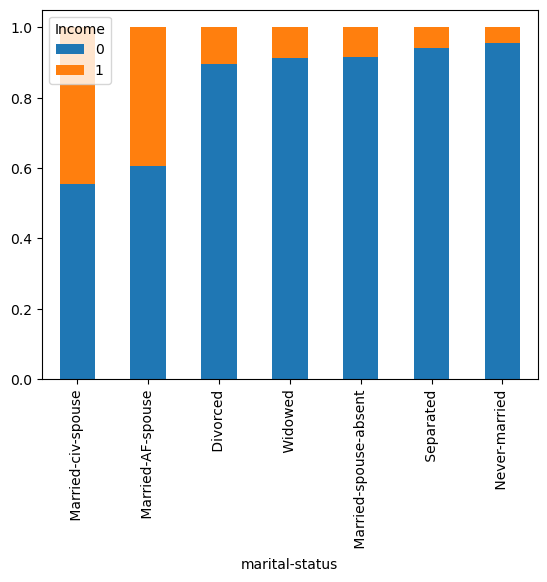

In [210]:
plot_proportion_for_category(trainval_data, 'marital-status')

Target value proportions fall into two groupings which we'll call 'yes' and 'no' and then one-hot encode

In [211]:
def handle_marital_status(data):
    mapping = {'Never-married':'no', 'Married-civ-spouse':'yes', 'Separated':'no', 'Widowed':'no',
       'Divorced':'no', 'Married-spouse-absent':'no', 'Married-AF-spouse':'yes'}
    data['marital-status'] = data['marital-status'].str.strip().replace(mapping)
    return pd.get_dummies(data, columns=['marital-status'], drop_first=True)

trainval_data = handle_marital_status(trainval_data)
test_data = handle_marital_status(test_data)

View the breakdown of target value by work class

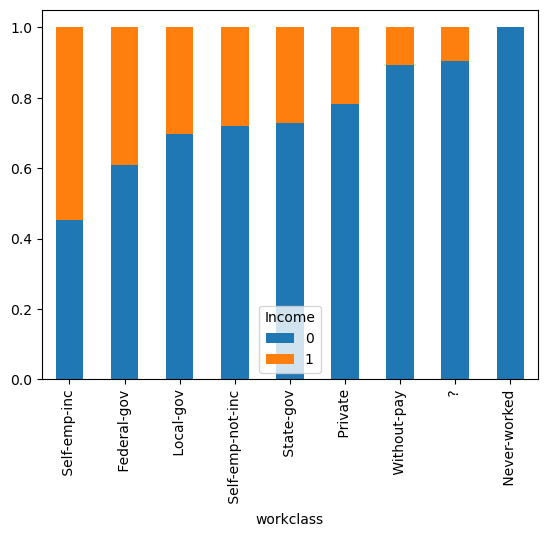

In [212]:
plot_proportion_for_category(trainval_data, 'workclass')

There are no clear groupings of work class by target value proportion, so we'll use one-hot encoding on the unchanged feature values

In [213]:
trainval_data = pd.get_dummies(trainval_data, columns=['workclass'], drop_first=True, )
test_data = pd.get_dummies(test_data, columns=['workclass'], drop_first=True, )

View the breakdown of target value by education

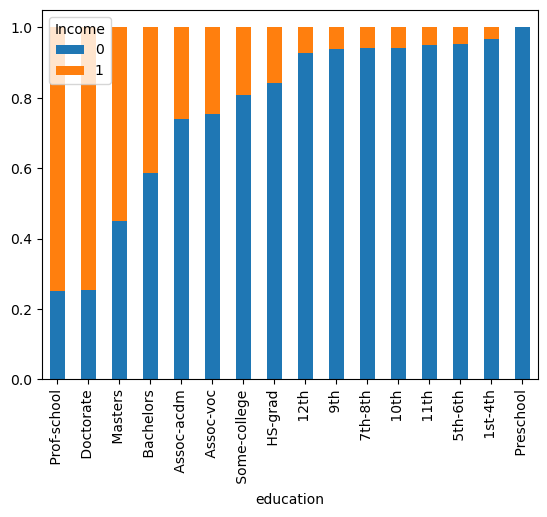

In [214]:
plot_proportion_for_category(trainval_data, 'education')

Group education values for K-12 grade and for Associates degrees

In [215]:
def handle_education(data):
    mapping = {'12th': 'K-12', '11th':'K-12', 'Doctorate':'Prof-school', 'Assoc-voc':'Assoc-acdm', 
               '9th':'K-12', '10th':'K-12', '1st-4th':'K-12', '5th-6th':'K-12', '7th-8th':'K-12'}
    data['education'] = data['education'].str.strip().replace(mapping)
    data.drop('education-num', axis=1, inplace=True)
    return pd.get_dummies(data, columns=['education'], drop_first=True)
    
trainval_data = handle_education(trainval_data)
test_data = handle_education(test_data)

View the breakdown of target value by occupation

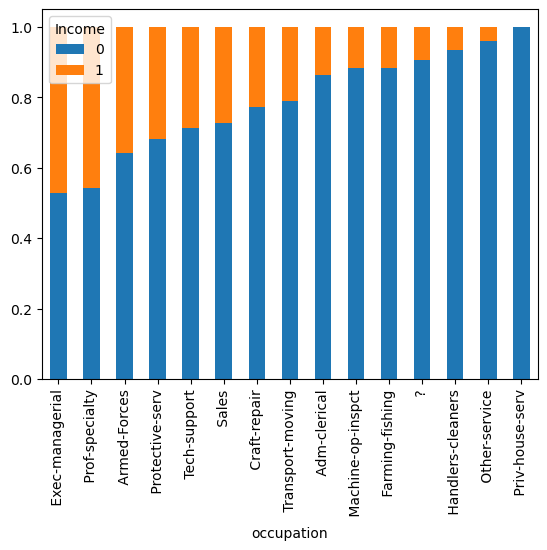

In [216]:
plot_proportion_for_category(trainval_data, 'occupation')

There don't seem to be meaningful groupings of occuption, so we'll one-hot encode the unchanged values below

View the breakdown of target value by relationship

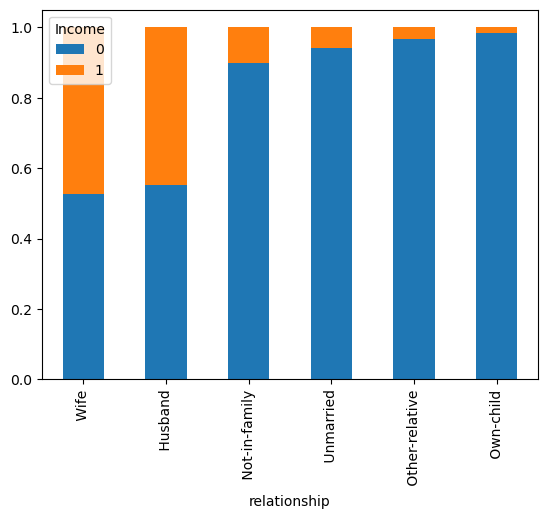

In [217]:
plot_proportion_for_category(trainval_data, 'relationship')

Leave relationship unchanged and one-hot encode below

View the breakdown of target value by race

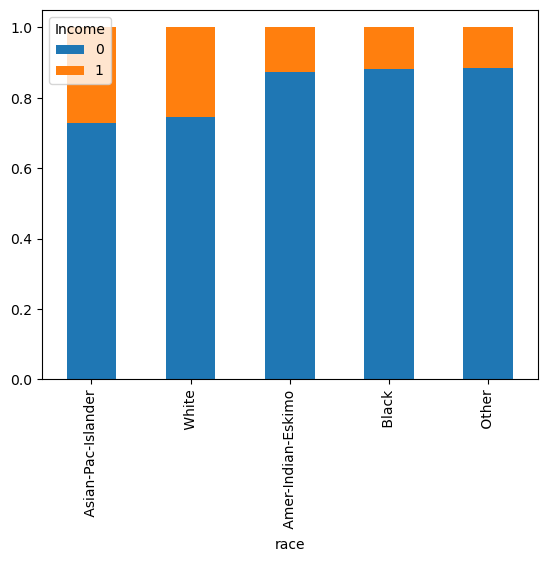

In [218]:
plot_proportion_for_category(trainval_data, 'race')

Group White and Asian into 'W/A' and other races into 'minority' and then one-hot encode

In [219]:
def handle_race(data):
    mapping = {'Asian-Pac-Islander':'W/A', 'Amer-Indian-Eskimo':'minority', 'Black':'minority', 'Other':'minority'}
    data['race'] = data['race'].str.strip().replace(mapping)
    return pd.get_dummies(data, columns=['race'], drop_first=True)

trainval_data = handle_race(trainval_data)
test_data = handle_race(test_data)

View the breakdown of target value by sex

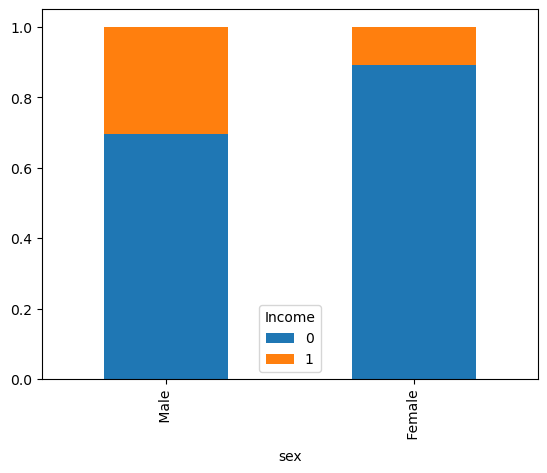

In [220]:
plot_proportion_for_category(trainval_data, 'sex')

One-hot encode features which have not been altered above

In [221]:
trainval_data = pd.get_dummies(trainval_data, columns=['occupation', 'relationship', 'sex'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['occupation', 'relationship', 'sex'], drop_first=True)

View the breakdown of target value by native country

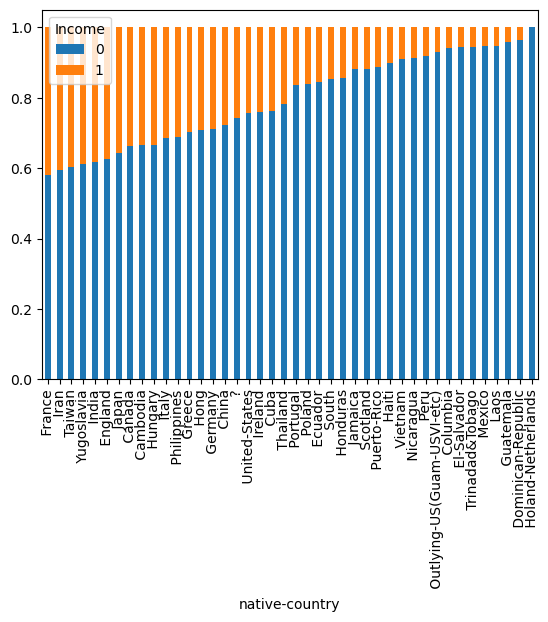

In [222]:
plot_proportion_for_category(trainval_data, 'native-country')

Use an ordinal feature for native country based on observed proportion of the target values in the training data between Netherlands and France

In [223]:
grouped_data = trainval_data.groupby('native-country')['Income'].value_counts(normalize=True).unstack().sort_values(by=0)
map = {value: index for index, value in enumerate(list(grouped_data.reset_index().iloc[:, 0]))}

def handle_native_country(data):
    data['country-index'] = data['native-country'].apply(lambda x: map[x])
    data.drop('native-country', axis=1, inplace=True)
    
handle_native_country(trainval_data)
handle_native_country(test_data)

View training data following preprocessing

In [224]:
trainval_data

,ID,age,fnlwgt,capital-gain,capital-loss,hours-per-week,Income,marital-status_yes,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_Bachelors,education_HS-grad,education_K-12,education_Masters,education_Preschool,education_Prof-school,education_Some-college,race_White,race_minority,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,country-index
0,34496,37,193106,0,0,30,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,17
1,18592,56,216636,0,1651,40,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17
2,12563,53,126977,0,0,35,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,17
3,553,72,205343,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,17
4,3480,46,106705,0,0,38,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,37701,45,37718,0,0,40,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,17
39069,16093,58,223400,0,0,20,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,17
39070,26499,61,229062,0,1887,40,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17
39071,20648,38,81965,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,17


Drop ID columns from feature sets

In [225]:
trainval_X = trainval_data.drop('ID', axis=1)
test_X = test_data.drop('ID', axis=1)

Remove Income from training data and use to create target value array

In [226]:
trainval_y = trainval_X.pop('Income')
features = trainval_X.columns

Normalize features and split into training and validation data sets

In [227]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(trainval_X)
trainval_X = sc.transform(trainval_X)
test_X = sc.transform(test_X)

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, test_size=0.2, random_state=1, stratify=trainval_y)

Define a helper method to fit models on training data and then show accuracy for training and validation datasets

In [228]:
from sklearn.metrics import accuracy_score
model_acc = []
def fit_model_and_get_accuracy(model, train_X=train_X, train_y=train_y, val_X=val_X, val_y=val_y):
    model.fit(train_X, train_y)
    
    train_yhat = model.predict(train_X)
    val_yhat = model.predict(val_X)
    
    train_acc = accuracy_score(train_y, train_yhat)
    val_acc = accuracy_score(val_y, val_yhat)
    
    model_acc.append([model.__class__.__name__, 'Training', train_acc])
    model_acc.append([model.__class__.__name__, 'Validation', val_acc])
    
    return train_acc, val_acc

# Logistic Regression - validation accuracy = 0.8543
Classify using Logistic Regression which applies a sigmoid threshold function to a linear combination of features. LR is a fast, easily explainable classifier, but not as powerful as other options

In [229]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
print(fit_model_and_get_accuracy(lr))

(0.8525817390747968, 0.854254638515675)


# SVM - validation accuracy = 0.8577
Classify using SVM/SVC with defaults (radial basis function kernel, C=1.0, Gamma=1 / (n_features * X.var())). SVM is very powerful with the RBF kernel which can handle non-linear relationships between features and target, however with some loss of efficiency and explainability.

In [230]:
from sklearn.svm import SVC
svc = SVC()
print(fit_model_and_get_accuracy(svc))

(0.8641627743297716, 0.8577095329494562)


# Decision Tree - validation accuracy = 0.8181
Classify using Decision Tree which uses a tree of if-else conditions to classify samples. Among the easiest classifiers to explain, but lacking the power of other options. Deep trees can overfit.

(0.823885085418133, 0.818170185540627)


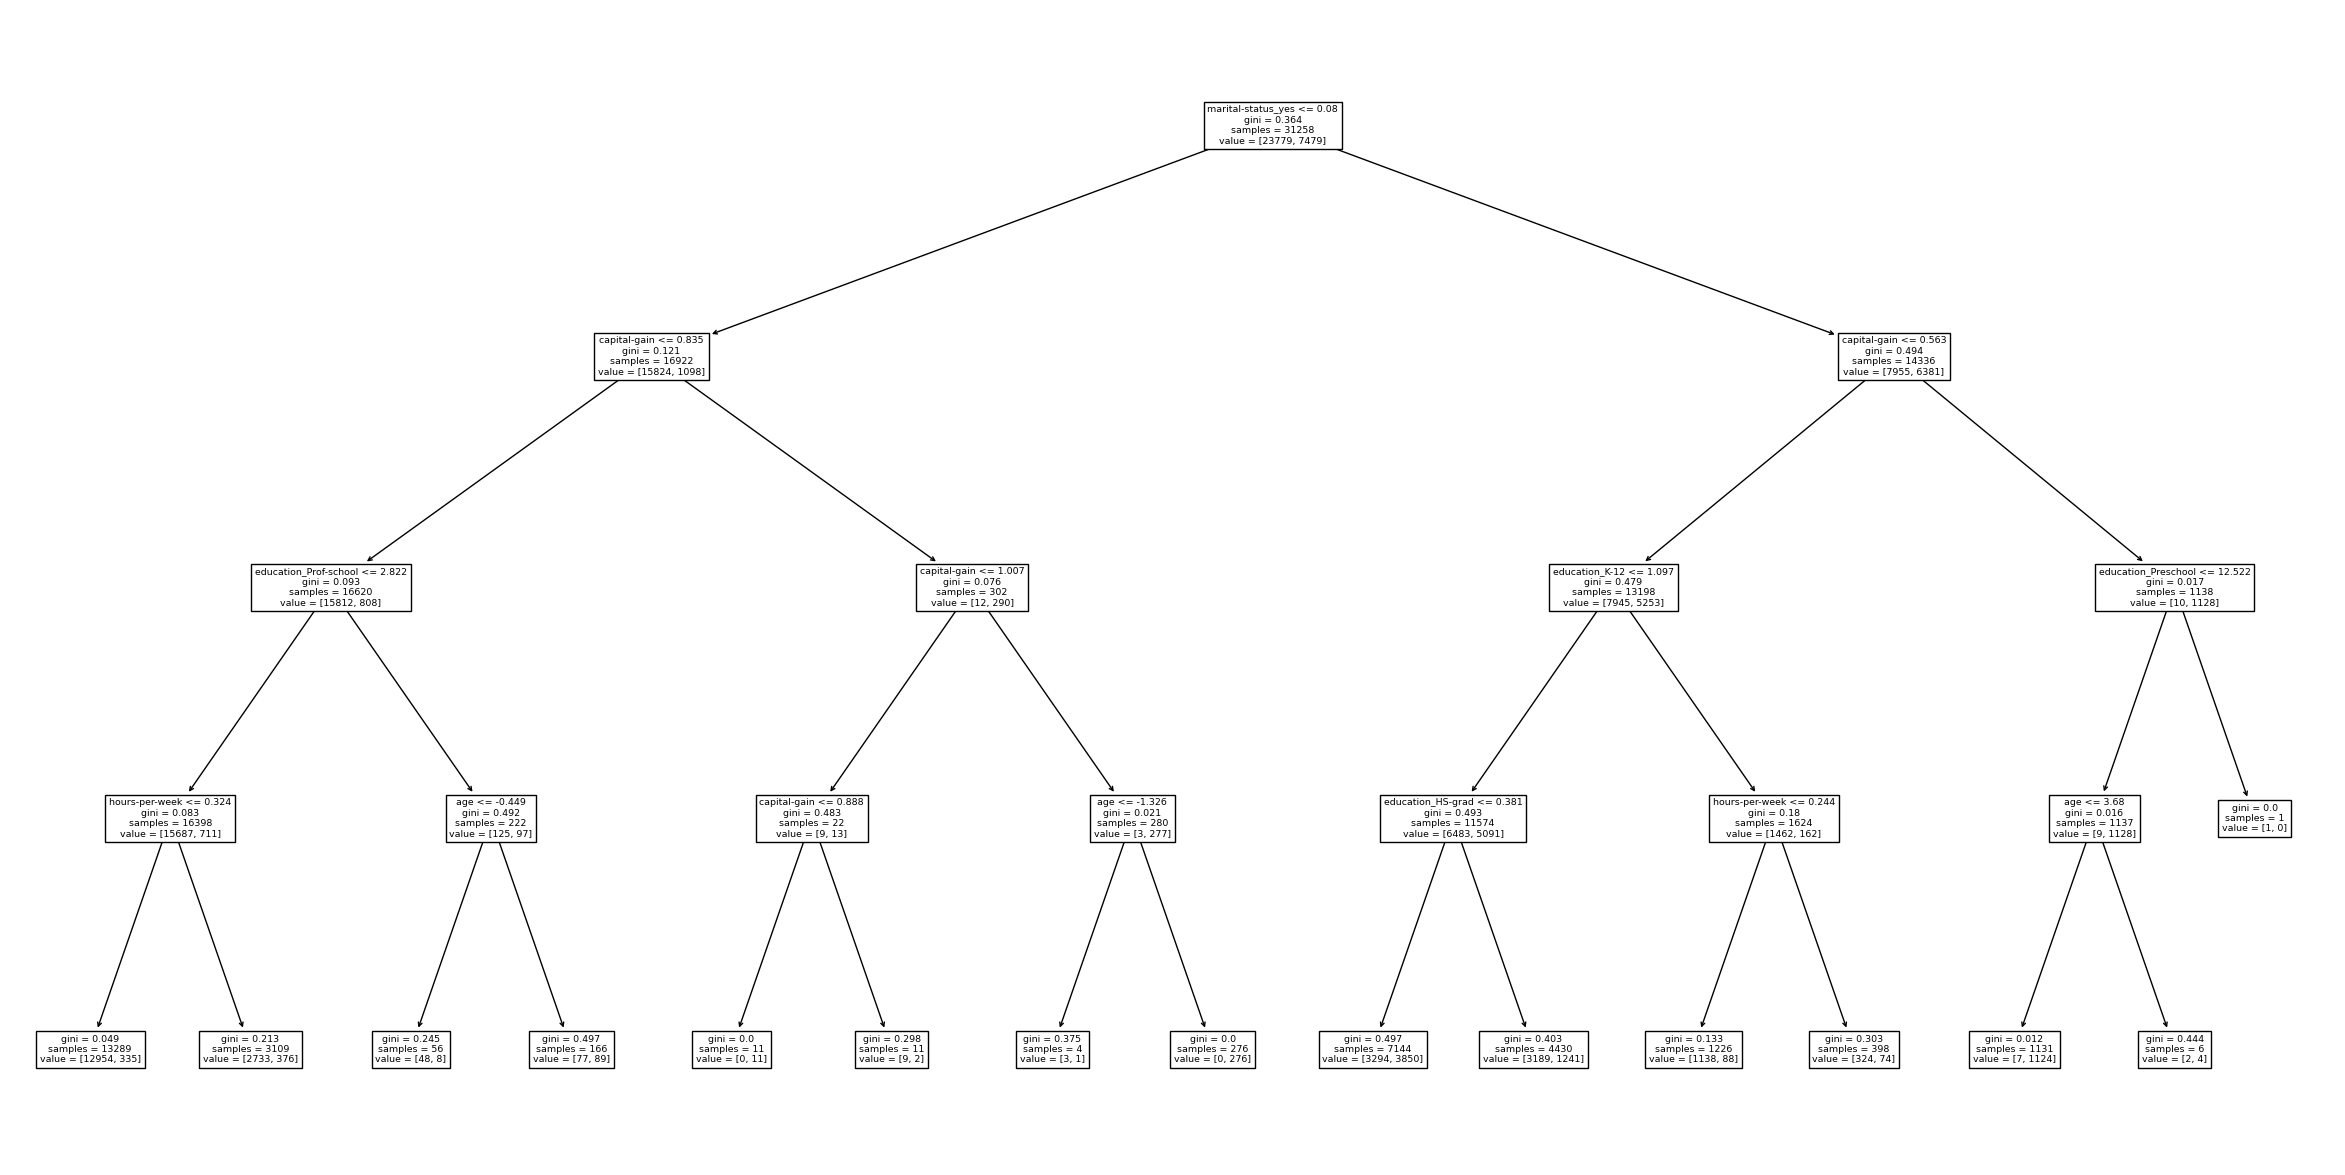

In [231]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier(max_depth=4)
print(fit_model_and_get_accuracy(dt))
plt.figure(figsize=(30, 15))
plot_tree(dt, feature_names=features)
plt.show()

# Random Forest - validation accuracy = 0.8567
Classify using Random Forest which creates an ensemble of relatively short decision trees. Voting mechanism allows for probability as an output. Largely resistant to overfitting, but can become inefficient if many trees are used.

In [232]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
print(fit_model_and_get_accuracy(rf))

(0.9998720327596136, 0.855022392834293)


The Random Forest seems to be overfitting. Try adjusting hyperparameters

In [242]:
for est in [5, 10, 15, 25, 50, 75, 125, 150, 200]:
    rf = RandomForestClassifier(n_estimators = est)
    print(est, fit_model_and_get_accuracy(rf))

5 (0.9793332906775866, 0.8391554702495202)
10 (0.9868833578603877, 0.8487523992322457)
15 (0.9942734659927058, 0.8474728087012157)
25 (0.997760573293237, 0.8524632117722328)
50 (0.9993281719879711, 0.852975047984645)
75 (0.9999040245697102, 0.8556621880998081)
125 (0.9999360163798068, 0.8568138195777352)
150 (0.9999360163798068, 0.8566858605246321)
200 (0.9999360163798068, 0.8555342290467051)


# K-Nearest Neighbors - validation accuracy = 0.8407
Classify using K-Nearest Neighbors which classifies samples based on the k closest samples. Provides explainability since neighbors can be inspected for a given test sample. Efficiency can decline with large values of k.

In [234]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
print(fit_model_and_get_accuracy(knn))

(0.8765755966472583, 0.8263595649392195)


There appears to be overfitting since training accuracy > validation accuracy. Try adjusting hyperparameters

In [235]:
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = k)
    print(k, fit_model_and_get_accuracy(knn))

1 (0.9999360163798068, 0.799232245681382)
2 (0.896474502527353, 0.8113883557261676)
3 (0.8969543796788022, 0.8202175303902751)
4 (0.8771194574189007, 0.8262316058861164)
5 (0.8765755966472583, 0.8263595649392195)
6 (0.8681297587817519, 0.8309660908509277)
7 (0.8679058161110755, 0.8325015994881638)
8 (0.8625631838249408, 0.8327575175943698)
9 (0.8616674131422356, 0.83531669865643)
10 (0.8585322157527673, 0.8348048624440179)
11 (0.8566127071469704, 0.8341650671785029)
12 (0.8540853541493377, 0.8359564939219449)
13 (0.8540213705291445, 0.83659628918746)
14 (0.8532855588969224, 0.836724248240563)
15 (0.8526137308848935, 0.838131797824696)
16 (0.851078124000256, 0.8406909788867563)
17 (0.8511421076204492, 0.8385156749840051)
18 (0.8498944270266812, 0.8382597568777991)
19 (0.8499584106468744, 0.835700575815739)


# Gradient Boosting - validation accuracy = 0.8714 - highest accuracy
Classify using Gradient Boosting which is similar to Random Forest, except that RF uses bagging whereas GB boosts with successive decision trees which correct the errors made by the previous tree. GB can be computationally intensive, though.

In [236]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
print(fit_model_and_get_accuracy(gb))

(0.8708170708298676, 0.8714011516314779)


Plot performance of various models

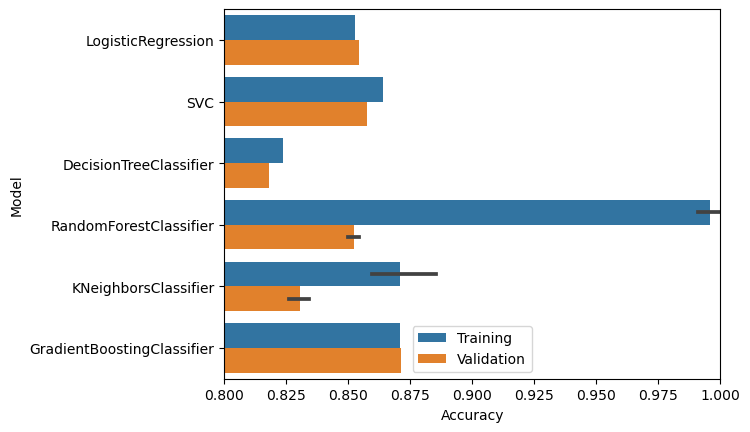

In [237]:
import seaborn as sns
df = pd.DataFrame(model_acc, columns=['Model', 'Data Set', 'Accuracy'])
sns.barplot(y='Model', x='Accuracy', hue='Data Set', data=df, orient='horizontal')
plt.legend(loc='lower center')
plt.xlim(0.8, 1.0)
plt.show()

Use Gradient Boosting since it is accurate for training and validation data sets. A GB model cannot be visualized as easily as a Decision Tree model, but we can view the most important features to gain an understanding of which features contribute most to prediction

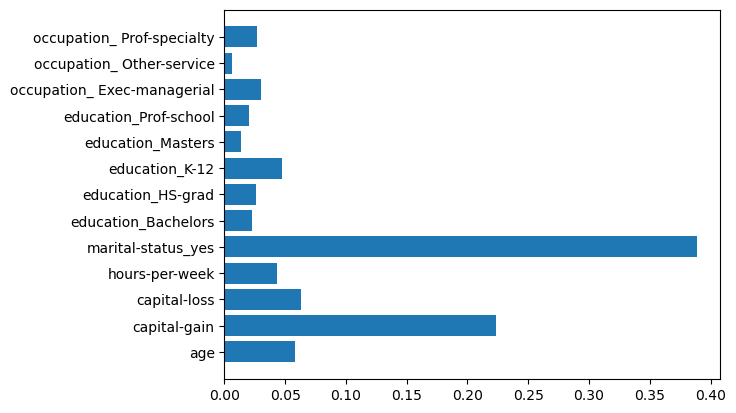

In [238]:
feature_importance = gb.feature_importances_
important_features = (feature_importance > 0.005)
plt.barh(features[important_features], feature_importance[important_features], align='center')
plt.show()

Create submission file

In [239]:
final_predictions = gb.predict(test_X)
print(final_predictions)

output = pd.DataFrame({'ID': test_data.ID, '0': final_predictions})
output.to_csv('submission.csv', index=False)

[0 0 0 ... 0 0 0]


Compare predicted proportions for test with actual proportions from training data as a sanity check before submission

In [244]:
print(trainval_y.value_counts(normalize=True))
print(output.iloc[:,1].value_counts(normalize=True))

0    0.76073
1    0.23927
Name: Income, dtype: float64
0    0.814003
1    0.185997
Name: 0, dtype: float64
